# ml lab3

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 0. read lab1 data

In [4]:
import os

DATA_PATH = '../lab1/data/notMNIST_small'

letters = sorted(os.listdir(DATA_PATH))

image_width = 28

labels = []
images = []

for l_id, letter in enumerate(letters):
    l_dir = f'{DATA_PATH}/{letter}'
    for image in os.listdir(l_dir):
        try:
            images.append(plt.imread(f'{l_dir}/{image}'))
            labels.append(l_id)
        except:
            continue

data = pd.DataFrame.from_dict({'image': images, 'label': labels})            

In [5]:
data.shape

(18724, 2)

In [6]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2)
test, val = train_test_split(test, test_size=0.25)

train.size, test.size, val.size

(29958, 5616, 1874)

### 1. build network

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [8]:
epochs = 100
output_size = len(letters)
learning_rate = 1e-3

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=0)

In [9]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(64 * 28 * 28, 512),
            nn.Linear(512, output_size),
        )
        

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
network = Network()
network.to(device)

Network(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=50176, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [10]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

transform = transforms.Compose([transforms.ToTensor()])

class ImageDataset(Dataset):
    def __init__(self, _data):
        print(len(_data))
        self.data = _data
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        image = self.data.iloc[i, 0]
        label = self.data.iloc[i, 1]
        return transform(np.uint8(image)), label

def get_loader(_data, batch_size=128, shuffle=False):
    return DataLoader(ImageDataset(_data), num_workers=8, batch_size=batch_size, shuffle=True)

train_loader = get_loader(train, 2048, True)
test_loader = get_loader(test)
val_loader = get_loader(val)

14979
2808
937


In [11]:
from tqdm import tqdm

loss_func = nn.CrossEntropyLoss()

def calculate_accuracy(_net, _data):
    correct = 0
    total = 0

    for imgs, lbls in _data:
        imgs = imgs.to(device)
        lbls = lbls.to(device)

        out = _net(imgs)
        _, predicted = torch.max(out.data, 1)

        total += lbls.size(0)
        correct += (predicted == lbls).sum()

    accuracy = correct.cpu().numpy() / total
    return accuracy


def train(_net, _opt):
    accs = []
    pbar = tqdm(range(epochs))
    for e in pbar:
        for i, (imgs, lbls) in enumerate(train_loader):
            imgs = imgs.to(device)
            lbls = lbls.to(device)

            out = _net(imgs)
            loss = loss_func(out, lbls)

            _opt.zero_grad()
            loss.backward()
            _opt.step()

        accuracy = calculate_accuracy(_net, test_loader)
        accs.append(accuracy)
        pbar.set_description(f'[e#{e} accuracy: {accuracy:.3f}]')
    return accs

In [12]:
import torch.optim as optim

optimizer = optim.Adagrad(network.parameters(), lr=learning_rate)

In [13]:
acc_log = train(network, optimizer)

[e#99 accuracy: 0.882]: 100%|██████████| 100/100 [06:00<00:00,  3.61s/it]


In [14]:
network.eval()

calculate_accuracy(network, train_loader), calculate_accuracy(network, test_loader)

(0.9825756058481875, 0.8839031339031339)

### 2. pooling

In [15]:
def _num_flat_features(x):
    size = x.size()[1:]
    num_features = 1
    for s in size:
        num_features *= s
    return num_features


class Network2(nn.Module):
    def __init__(self):
        super(Network2, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(3136, 512),
            nn.Linear(512, output_size),
        )
    
    def num_flat_features(self, x):
        return _num_flat_features(x)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [16]:
network2 = Network2()
network2.to(device)

Network2(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [17]:
optimizer2 = optim.Adagrad(network2.parameters(), lr=learning_rate)
acc_log2 = train(network2, optimizer2)

[e#99 accuracy: 0.908]: 100%|██████████| 100/100 [02:28<00:00,  1.48s/it]


In [18]:
network2.eval()

calculate_accuracy(network2, train_loader), calculate_accuracy(network2, test_loader)

(0.9297015822151011, 0.907051282051282)

### 3. `LeNet-5`

In [19]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)

        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, output_size)
    
    def num_flat_features(self, x):
        return _num_flat_features(x)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [20]:
network3 = LeNet()
network3.to(device)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [40]:
optimizer3 = optim.AdamW(network3.parameters(), lr=learning_rate)
acc_log3 = train(network3, optimizer3)

[e#99 accuracy: 0.831]: 100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


In [41]:
network3.eval()

calculate_accuracy(network3, train_loader), calculate_accuracy(network3, test_loader)

(0.8349689565391548, 0.8311965811965812)

### 4. results

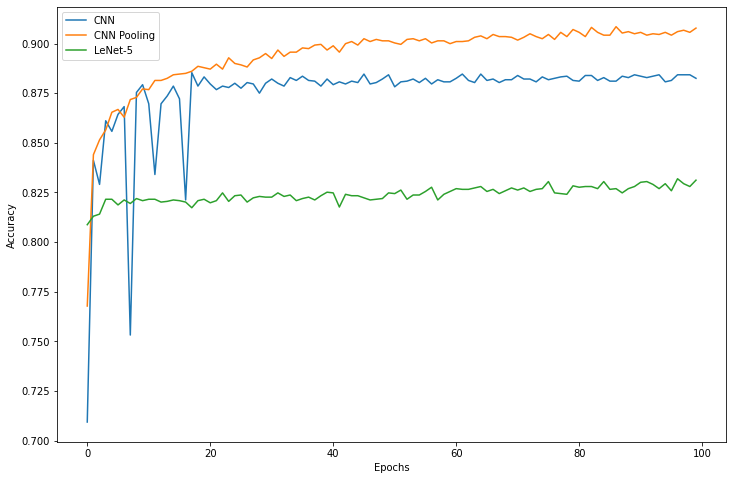

In [42]:
plt.figure(figsize=(12, 8))
plt.plot(acc_log, label='CNN')
plt.plot(acc_log2, label='CNN Pooling')
plt.plot(acc_log3, label='LeNet-5')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()